In [15]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from matplotlib.dates import YearLocator, DateFormatter

# Set style for all plots
plt.style.use('fivethirtyeight')  # Using a built-in matplotlib style
sns.set_palette("deep")
plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

# Load the enriched dataset
df = pd.read_csv('../data/enriched_merged_stocks.csv')
df['Date'] = pd.to_datetime(df['Date'])


C:\Users\techs\AppData\Local\Temp\ipykernel_15128\1155397974.py:19: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['Date'] = pd.to_datetime(df['Date'])



Observations for AAPL RSI Analysis:
- Oversold conditions (<30 RSI) detected on: 2021-02-25, 2021-02-26, 2022-09-30
- Overbought conditions (>70 RSI) detected on: 2020-08-05, 2020-08-06, 2020-08-20


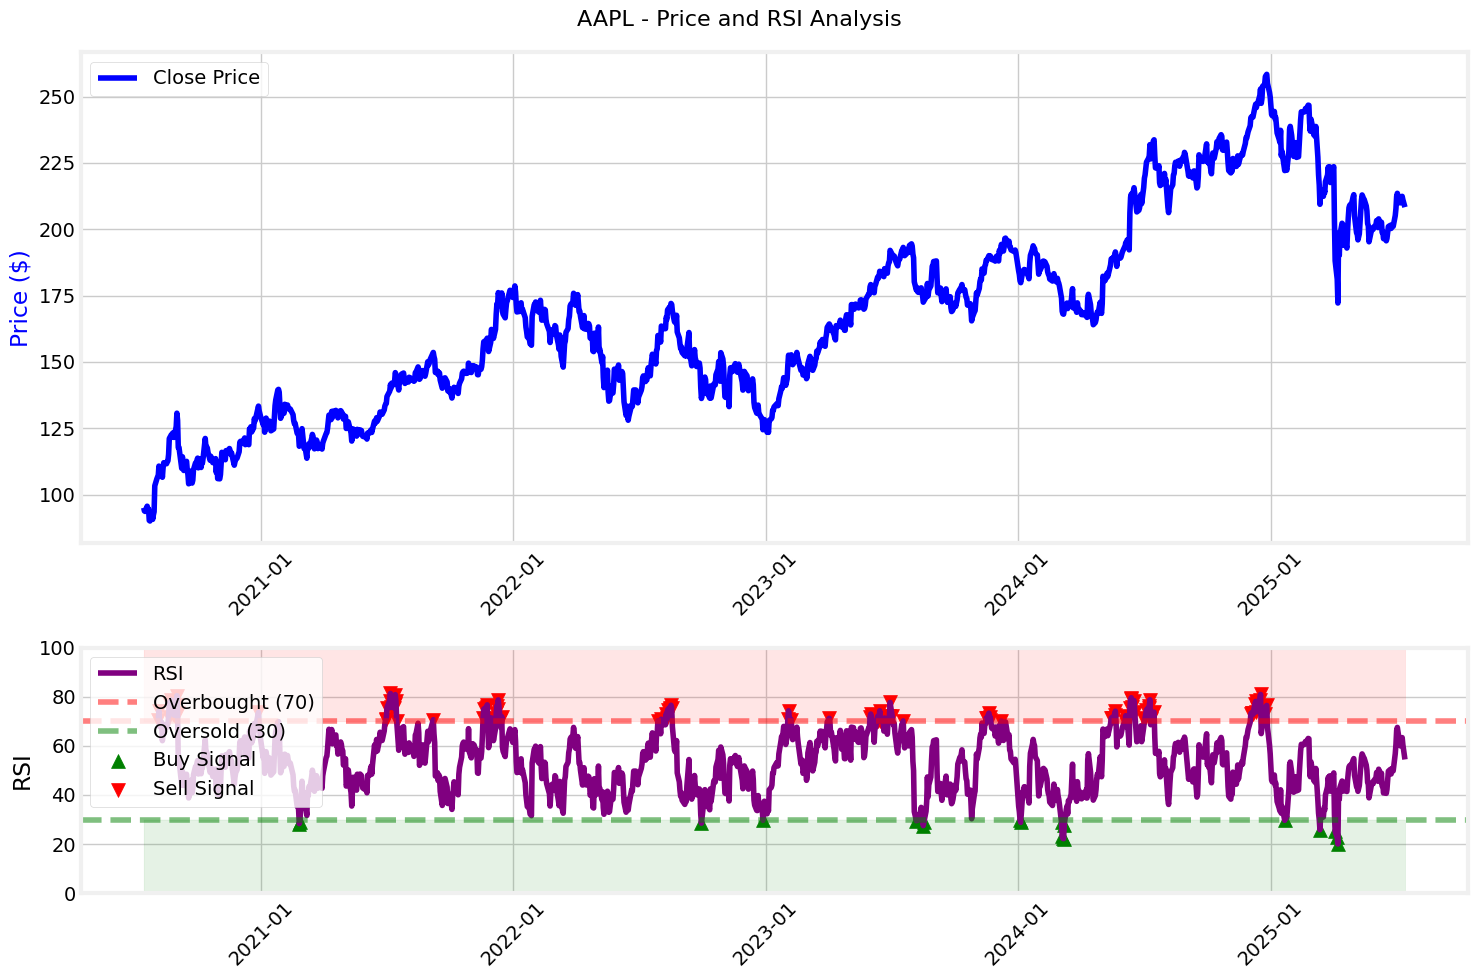


Observations for TSLA RSI Analysis:
- Oversold conditions (<30 RSI) detected on: 2021-03-05, 2021-03-08, 2022-05-12
- Overbought conditions (>70 RSI) detected on: 2020-08-20, 2020-08-21, 2020-08-24


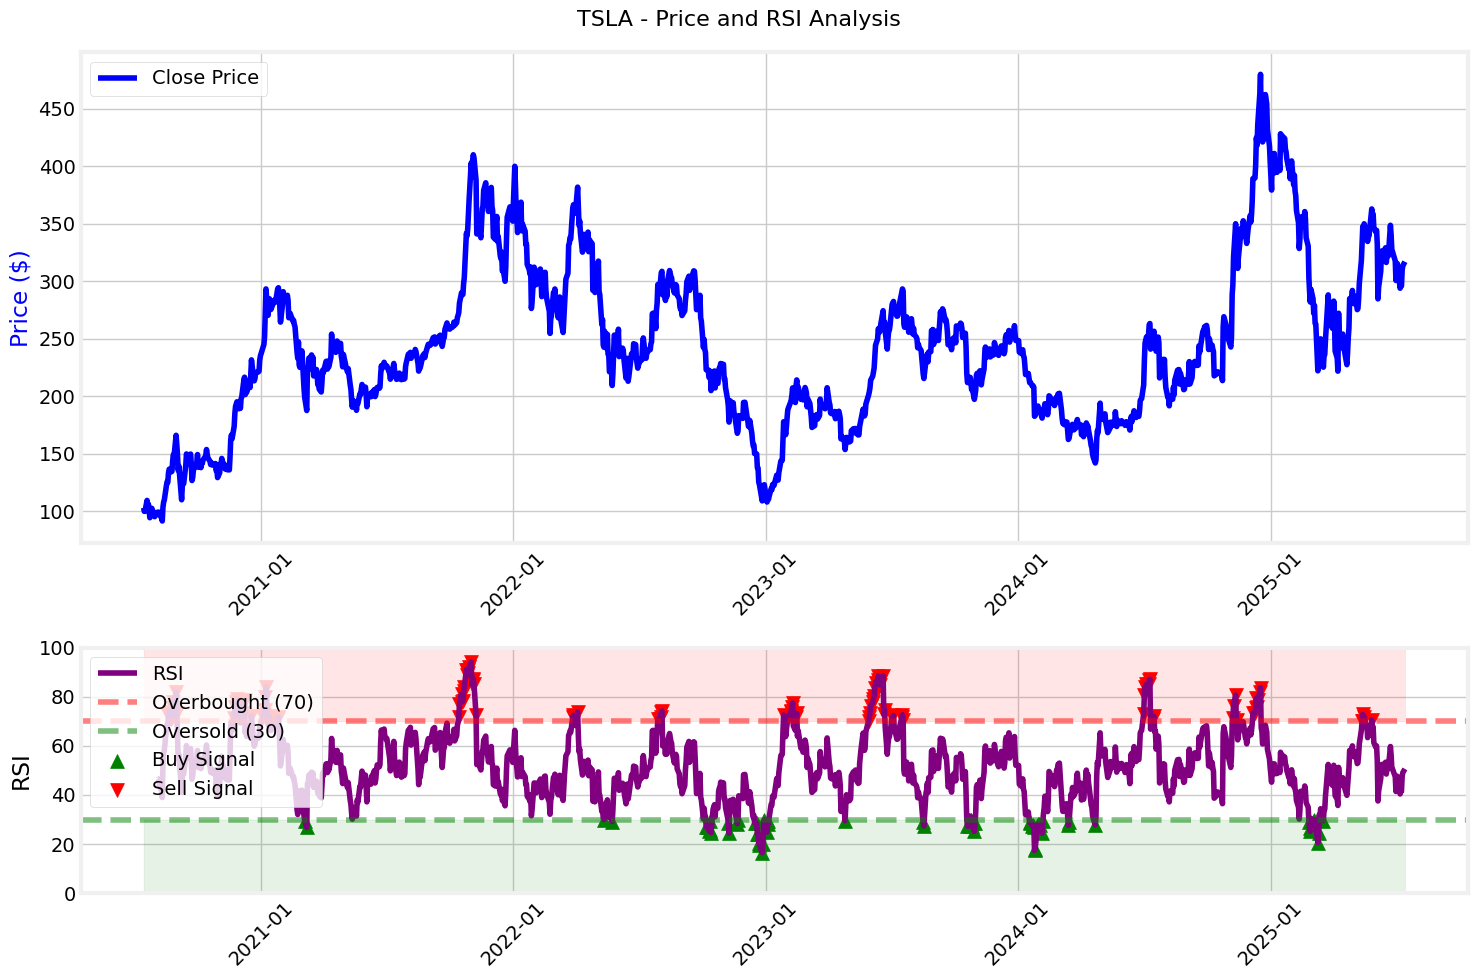


Observations for MSFT RSI Analysis:
- Oversold conditions (<30 RSI) detected on: 2022-01-25, 2022-09-06, 2022-09-20
- Overbought conditions (>70 RSI) detected on: 2021-01-28, 2021-02-12, 2021-04-13


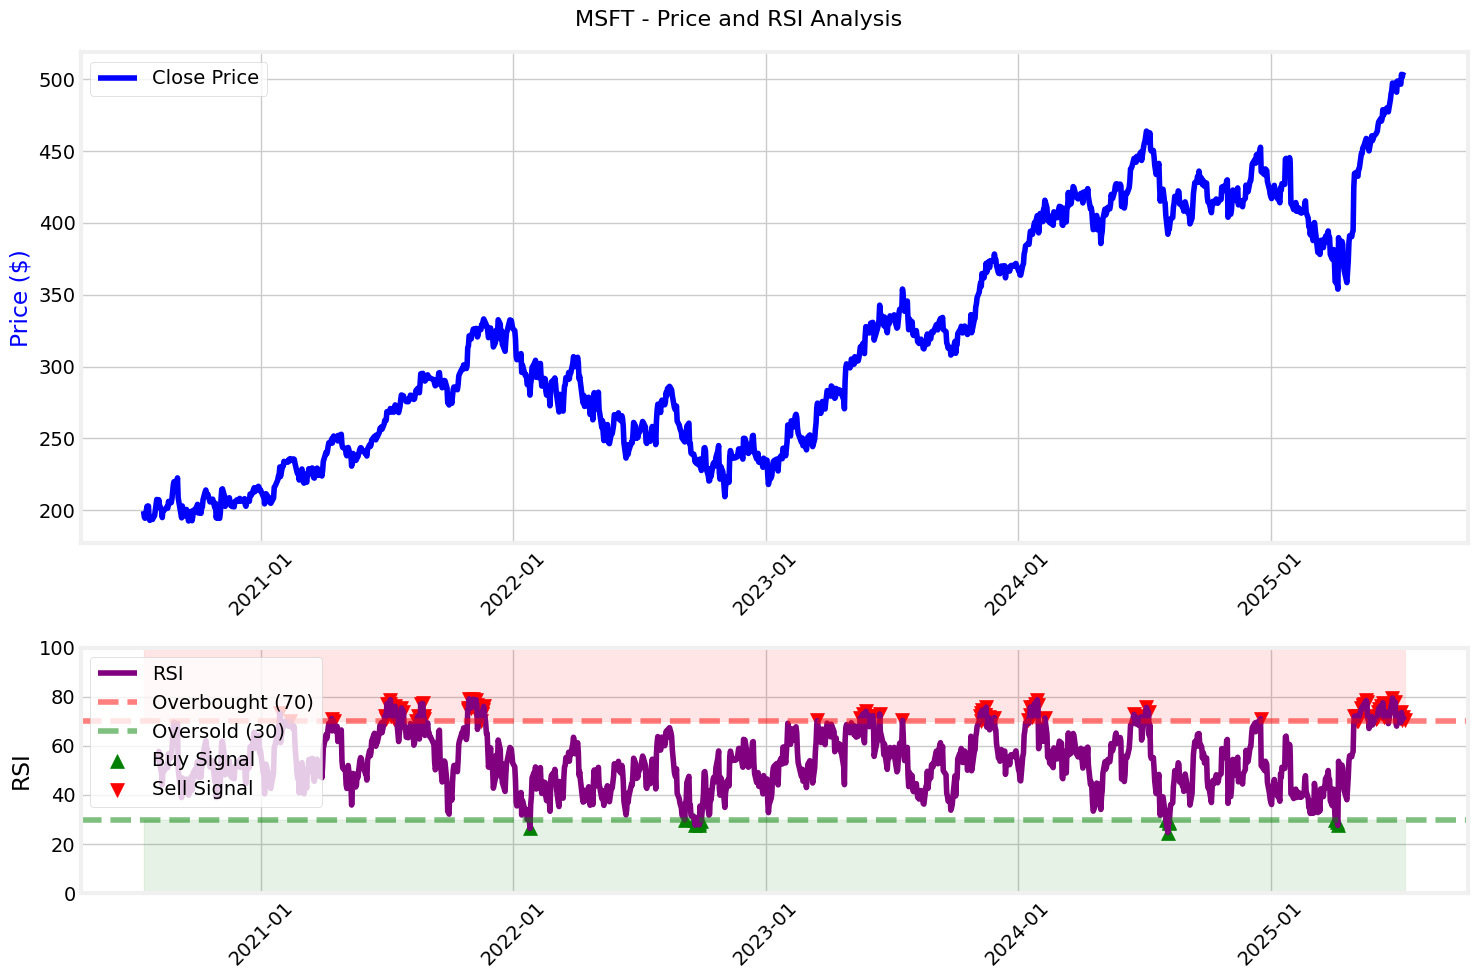

In [16]:
def plot_rsi_analysis(stock_data, ticker):
    """Create a dual-axis plot of Close price vs RSI with signal zones"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), height_ratios=[2, 1])
    fig.suptitle(f'{ticker} - Price and RSI Analysis', fontsize=16)
    
    # Plot price
    ax1.plot(stock_data['Date'], stock_data['Close'], label='Close Price', color='blue')
    ax1.set_ylabel('Price ($)', color='blue')
    ax1.xaxis.set_major_locator(YearLocator())
    ax1.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
    ax1.legend(loc='upper left')
    
    # Plot RSI
    ax2.plot(stock_data['Date'], stock_data['RSI'], label='RSI', color='purple')
    ax2.axhline(y=70, color='r', linestyle='--', alpha=0.5, label='Overbought (70)')
    ax2.axhline(y=30, color='g', linestyle='--', alpha=0.5, label='Oversold (30)')
    ax2.fill_between(stock_data['Date'], 70, 100, color='r', alpha=0.1)
    ax2.fill_between(stock_data['Date'], 0, 30, color='g', alpha=0.1)
    
    # Find and mark significant RSI signals
    buy_signals = stock_data[stock_data['RSI'] < 30]
    sell_signals = stock_data[stock_data['RSI'] > 70]
    
    if len(buy_signals) > 0:
        ax2.scatter(buy_signals['Date'], buy_signals['RSI'], 
                   color='g', marker='^', s=100, label='Buy Signal')
    if len(sell_signals) > 0:
        ax2.scatter(sell_signals['Date'], sell_signals['RSI'], 
                   color='r', marker='v', s=100, label='Sell Signal')
    
    ax2.set_ylabel('RSI')
    ax2.set_ylim(0, 100)
    ax2.xaxis.set_major_locator(YearLocator())
    ax2.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
    ax2.legend(loc='upper left')
    
    plt.tight_layout()
    
    # Generate observations
    observations = []
    if len(buy_signals) > 0:
        # Format dates for buy signals
        buy_dates = buy_signals['Date'].head(3).apply(lambda x: x.strftime('%Y-%m-%d') if isinstance(x, pd.Timestamp) else pd.to_datetime(x).strftime('%Y-%m-%d'))
        observations.append(f"Oversold conditions (<30 RSI) detected on: {', '.join(buy_dates)}")
    if len(sell_signals) > 0:
        # Format dates for sell signals
        sell_dates = sell_signals['Date'].head(3).apply(lambda x: x.strftime('%Y-%m-%d') if isinstance(x, pd.Timestamp) else pd.to_datetime(x).strftime('%Y-%m-%d'))
        observations.append(f"Overbought conditions (>70 RSI) detected on: {', '.join(sell_dates)}")
    
    return observations

# Plot RSI analysis for each stock
for ticker in ['AAPL', 'TSLA', 'MSFT']:
    stock_data = df[df['Ticker'] == ticker].copy()
    observations = plot_rsi_analysis(stock_data, ticker)
    
    print(f"\nObservations for {ticker} RSI Analysis:")
    for obs in observations:
        print(f"- {obs}")
    plt.show()
